##  Descarga y Limpieza de Datos Financieros (BBVA y Santander)

### Descarga desde Yahoo Finance  

Se obtuvieron los datos históricos de cotización de **BBVA (BBVA.MC)** y **Banco Santander (SAN.MC)** desde el **1 de enero de 2000** hasta el **31 de octubre de 2025**, utilizando la librería *yfinance*.  

Los archivos descargados incluyen información diaria de mercado: precios de apertura, cierre, máximos, mínimos, volumen y dividendos.  
Cada uno se guardó en la carpeta `../data/raw/precios/` con los nombres **BBVA.csv** y **SANTANDER.csv**.  

Estos CSV presentan varias líneas de encabezado (por ejemplo: “Price”, “Ticker”, “Date,,,,,”) antes de los datos reales, lo que hizo necesaria una limpieza previa al análisis.

---

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


BBVA Data:
Price      Adj Close      Close Dividends       High        Low       Open  \
Ticker       BBVA.MC    BBVA.MC   BBVA.MC    BBVA.MC    BBVA.MC    BBVA.MC   
Date                                                                         
2000-01-03  4.040033  13.623349       0.0  13.757854  13.594527  13.690602   
2000-01-04  3.934618  13.267874       0.0  13.536882  13.219837  13.450416   
2000-01-05  3.846296  12.970044       0.0  13.210230  12.912399  13.142977   
2000-01-06  3.846296  12.970044       0.0  12.970044  12.970044  12.970044   
2000-01-07  3.894730  13.133370       0.0  13.248659  12.998866  13.248659   

Price      Stock Splits    Volume  
Ticker          BBVA.MC   BBVA.MC  
Date                               
2000-01-03          0.0   8244257  
2000-01-04          0.0   8522096  
2000-01-05          0.0  12159826  
2000-01-06          0.0         0  
2000-01-07          0.0  62261944   

SANTANDER Data:
Price      Adj Close     Close Dividends      High       L

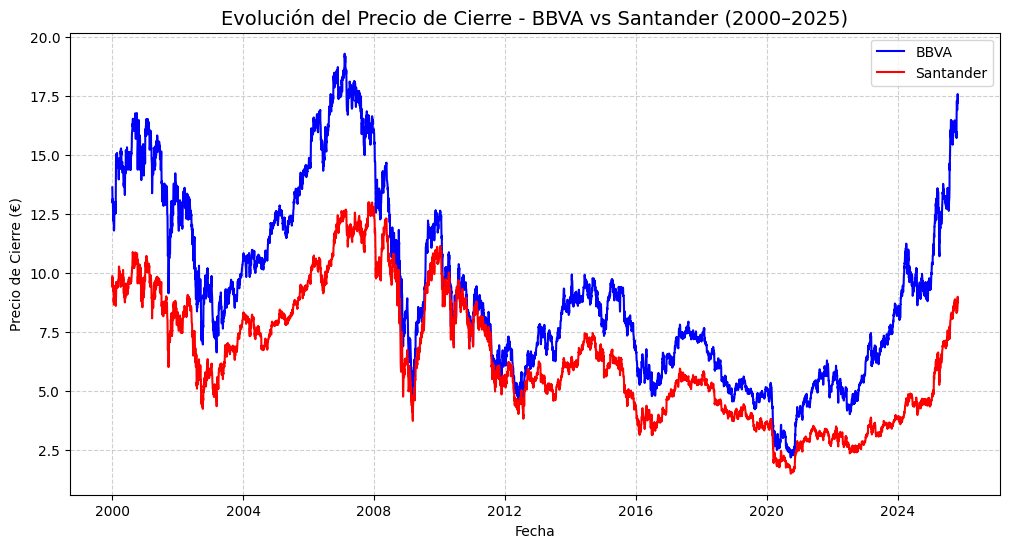

In [1]:
import yfinance as yf
import pandas as pd
import os

# ===========================================
# 1️⃣ Crear carpeta 'data' si no existe
# ===========================================
os.makedirs("../data", exist_ok=True)

# ===========================================
# 2️⃣ Definir símbolos y rango de fechas
# ===========================================
bbva_ticker = "BBVA.MC"       # Acción BBVA
santander_ticker = "SAN.MC"   # Acción Santander

start_date = "2000-01-01"
end_date = "2025-10-31"

# ===========================================
# 3️⃣ Descargar datos desde Yahoo Finance
# ===========================================
bbva_data = yf.download(bbva_ticker, start=start_date, end=end_date, auto_adjust=False, actions=True)
santander_data = yf.download(santander_ticker, start=start_date, end=end_date, auto_adjust=False, actions=True)

# Mostrar una vista rápida
print("BBVA Data:")
print(bbva_data.head(), "\n")
print("SANTANDER Data:")
print(santander_data.head(), "\n")

# ===========================================
# 4️⃣ Guardar los datos en carpeta /data
# ===========================================
bbva_data.to_csv("../data/BBVA.csv", index=True)
santander_data.to_csv("../data/SANTANDER.csv", index=True)

print("✅ Archivos guardados correctamente en la carpeta /data")

# ===========================================
# 5️⃣ Visualizar precios de cierre
# ===========================================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(bbva_data.index, bbva_data['Close'], label='BBVA', color='blue')
plt.plot(santander_data.index, santander_data['Close'], label='Santander', color='red')
plt.title('Evolución del Precio de Cierre - BBVA vs Santander (2000–2025)', fontsize=14)
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (€)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

###  Limpieza y Estructuración  

Los ficheros descargados desde Yahoo tienen una estructura irregular, donde la primera columna (“Price”) no contiene datos válidos, sino que ocupa el lugar donde debería estar la fecha.  

Durante la limpieza se realizaron los siguientes pasos:  

1. Se eliminaron las tres primeras filas de encabezado (“Price”, “Ticker” y “Date”).  
2. Se descartó la columna **Price**, ya que no contenía información útil.  
3. Se interpretó correctamente la columna **Date** como variable temporal.  
4. Se mantuvieron todos los valores numéricos exactamente como estaban, sin redondear ni alterar decimales.  
5. Se añadió la columna **Dividends_bin**, con valor `1` si hubo dividendo (`Dividends > 0`) y `0` si no.  
6. Se ordenaron las fechas y se eliminaron duplicados.  

Los resultados se guardaron en la carpeta `../data/interim/precios_limpios/` con los nombres **BBVA_core_clean.csv** y **SAN_core_clean.csv**.




###  Estructura del dataset

El dataset incluye las siguientes columnas:

- **Date**: Fecha de la transacción bursátil.  
- **Open**: Precio de apertura de la acción.  
- **High**: Precio máximo alcanzado durante el día.  
- **Low**: Precio mínimo alcanzado durante el día.  
- **Close**: Precio de cierre ajustado para reflejar divisiones de acciones.  
- **Adj Close**: Precio de cierre ajustado tanto para divisiones como para dividendos.  
- **Volume**: Número de acciones negociadas durante el día.  


In [7]:
import pandas as pd
from pathlib import Path

RAW_DIR = Path("../data/raw/precios")
OUT_DIR = Path("../data/interim/precios_limpios")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def reparar_yahoo_web_csv(path_in: Path, nombre_out: str):
    # 1️⃣ Leer cabeceras (primera fila)
    header1 = pd.read_csv(path_in, header=None, nrows=1, dtype=str, engine="python").iloc[0].tolist()

    # 2️⃣ Quitar la primera columna ('Price'), que es la falsa
    header1 = header1[1:]

    # 3️⃣ Leer los datos reales saltando las tres primeras filas (Price / Ticker / Date)
    cols = ['Date'] + header1
    data = pd.read_csv(
        path_in,
        header=None,
        names=cols,
        skiprows=3,
        dtype=str,           # todo se mantiene como texto
        engine="python"
    )

    # 4️⃣ Convertir la fecha (sin tocar el resto)
    data['Date'] = pd.to_datetime(data['Date'], errors="coerce")

    # 5️⃣ Crear columna binaria de dividendos SIN convertir a numérico
    if 'Dividends' in data.columns:
        # 1 si el texto de la celda no es "0" o "0.0" o está vacío
        data['Dividends_bin'] = data['Dividends'].apply(
            lambda x: 1 if pd.notna(x) and str(x).strip() not in {"", "0", "0.0", "0.00"} else 0
        )

    # 6️⃣ Limpiar filas vacías o duplicadas de fecha
    data = (
        data.dropna(subset=['Date'])
            .drop_duplicates(subset=['Date'])
            .sort_values('Date')
            .reset_index(drop=True)
    )

    # 7️⃣ Guardar exactamente igual (sin alterar decimales)
    out_path = OUT_DIR / f"{nombre_out}_core_clean.csv"
    data.to_csv(out_path, index=False, quoting=1)  # quoting=1 → preserva formato original
    print(f"✅ {nombre_out}: {len(data)} filas limpias (sin redondear) → {out_path}")
    return data

# Ejecutar
bbva = reparar_yahoo_web_csv(RAW_DIR / "BBVA.csv", "BBVA")
san  = reparar_yahoo_web_csv(RAW_DIR / "SANTANDER.csv", "SAN")


✅ BBVA: 6634 filas limpias (sin redondear) → ..\data\interim\precios_limpios\BBVA_core_clean.csv
✅ SAN: 6634 filas limpias (sin redondear) → ..\data\interim\precios_limpios\SAN_core_clean.csv


### 4️⃣ Justificación del tratamiento de los dividendos  

El valor exacto del dividendo no siempre es relevante para el análisis de comportamiento de precios.  
Lo importante es identificar **el evento de pago** de dividendos, que puede influir en la cotización o en los indicadores financieros.  

Por ello se creó **Dividends_bin**, una versión simplificada en formato binario:  
- `1` cuando hubo pago de dividendo.  
- `0` cuando no hubo.  

Esto permite incorporar los dividendos como variable categórica o evento en modelos de análisis temporal, predicciones o estudios de impacto financiero.

---

### 5️⃣ Resultado final  

Tras el proceso, se obtuvieron series limpias, completas y coherentes para ambos bancos, sin redondeos ni errores de alineación, y con la marca binaria de dividendos incluida.  

**Estructura final de carpetas:**

data/  
 ├── raw/precios/ → archivos originales descargados desde Yahoo Finance  
 └── interim/precios_limpios/ → archivos limpios listos para análisis  

Con estos datos ya preparados, el proyecto puede continuar con análisis temporales, correlaciones con sentimiento, indicadores técnicos y modelización predictiva.
